# Data Generation

This notebook covers optional code to recreate the artificially created real estate assets. To spare API costs, the whole generation can be skipped and alternatively the pre-generated content can be utilized, in the provided pickle file _generated_raw_assets.pickle_

**Note**: this Jupyter notebook does not to be run directly, it can be executed from _real_estate_agent.ipynb_ directly. If unsure leave thise notebook

First let's verify basic OpenAI operability

In [1]:
import openai
import os
from openai import OpenAI

with open("../open_ai.api_key", "r") as keyfile:
    key = keyfile.readline().replace("\n","")
    assert len(key.split()) == 1, f"expecting only the personal OpenAI API key, got >> {key.split()} << instead"
    
# Quick API check
client = OpenAI(api_key=key)
client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {'role': 'user', 'content': 'What is a good question?'}
            ],
            temperature=0,
            max_tokens=100)

ChatCompletion(id='chatcmpl-AwoxUvVK5ljfM665oae2hS8TaCaVv', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='A good question is one that is thought-provoking, open-ended, and prompts meaningful discussion or reflection. It should be clear, concise, and relevant to the topic at hand. Good questions can also challenge assumptions, spark curiosity, and encourage critical thinking.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1738582272, model='gpt-3.5-turbo-0125', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens=53, prompt_tokens=13, total_tokens=66, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

# LLM Interaction

To facilitate the code handling, first a common interface to the LLM is created, so the focus can be on the specific real estate case and not unrelated API handling.

Question:
What is a wonderful place to look for in a new home?

Response:
A wonderful place to look for in a new home can vary depending on individual preferences and priorities. However, some popular factors to consider include:

1. Safety: Look for neighborhoods with low crime rates and a strong sense of community safety.

2. Schools: Consider the quality of schools in the area, especially if you have children or are planning to start a family.

3. Amenities: Check for nearby amenities such as parks, shopping centers, restaurants, and recreational facilities.

4. Commute: Consider the proximity to your workplace and accessibility to public transportation if needed.

5. Nature and green spaces: Look for areas with parks, trails, or natural surroundings if you enjoy outdoor activities.

6. Affordability: Make sure the cost of living in the area aligns with your budget and financial goals.

Ultimately, the best place to look for in a new home is one that aligns with your lifestyle, pref

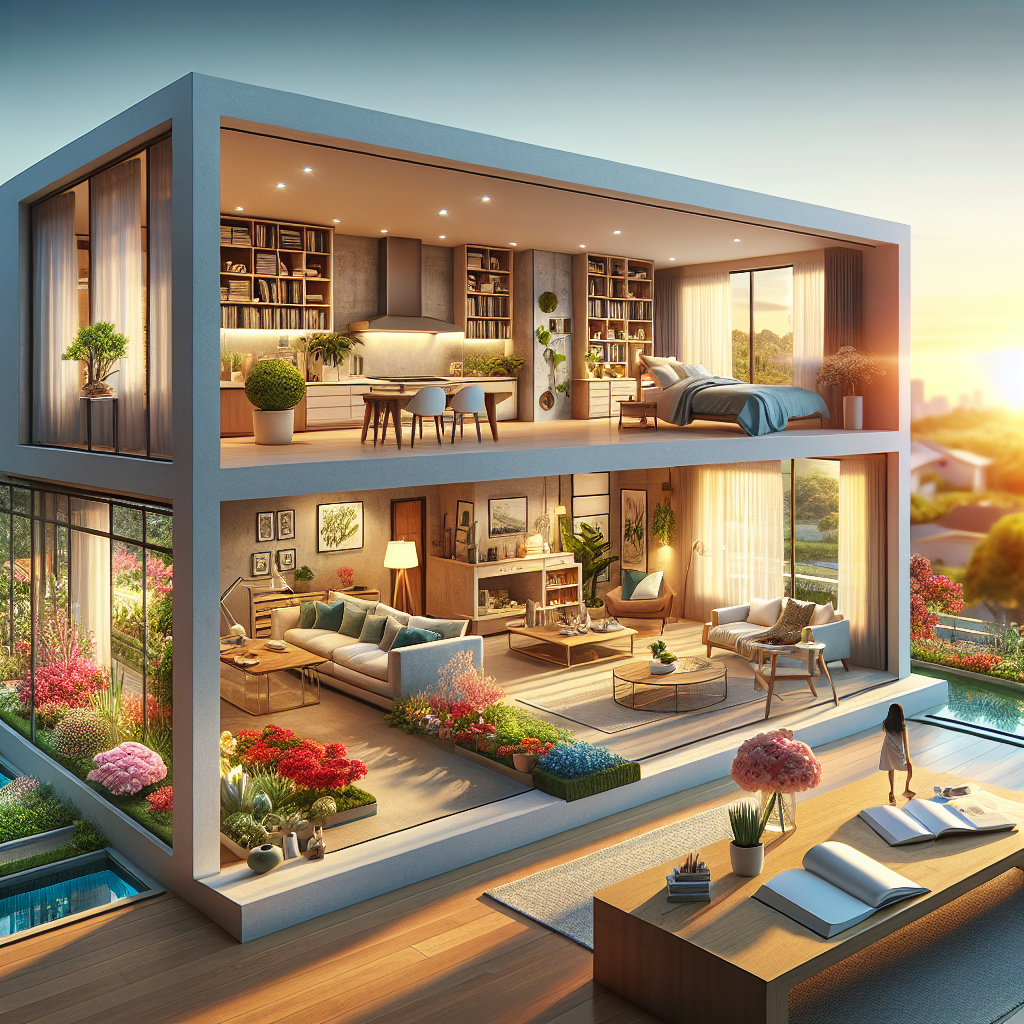

In [2]:
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

class GenAI:
    def __init__(self, key):
        self._client = OpenAI(api_key=key)

    def query_LLM(self,
            prompt,
            model="gpt-3.5-turbo",
            temperature=0.5,
            max_tokens=1000,
            response_format="json"):

        messages = [
            {"role": "system", "content": "You are a helpful data creator"},
            {"role": "user", "content": prompt},
        ]
        
        response = self._client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens)

        if "error" in response:
            raise openai.InvalidRequestError(response["error"], param=None)
        else:
            return response.choices[0].message.content

    def query_image_generator(self,
            prompt,
            model="dall-e-3",
            quality="standard",
            ):
        response = self._client.images.generate(
            model="dall-e-3",
            prompt=prompt,
            quality=quality
        )
        
        image_url = response.data[0].url
        image_response = requests.get(image_url) 
        return Image.open(BytesIO(image_response.content)) 

client = GenAI(key)

# quick test
query = "What is a wonderful place to look for in a new home?"
response = client.query_LLM(query)
image = client.query_image_generator(query)
print(f"Question:\n==========\n{query}\n\nResponse:\n==========\n{response}\n==========\n")
display(image)

## Creating content

The LLM should create artifical real estate data. To make these offers a bit more versatile, the LLM is supported with a set of attributes that it should describe for each item.

In [3]:
city = "Nuremberg"
style = "arbitrary, individual, low-correlating"
categories = [
    ("Neighborhood", "The name of the area"),
    ("Price", "The value for the housing object"),
    ("Bedrooms", "The amount of bedrooms the housing object offers"),
    ("Bathrooms", "The amount of bathrooms the housing object offers"),
    ("Living space", "The area that the housing object offers in square meters"),
    ("Neighborhood description", "A description what the vicinity looks like"),
    ("Parking space", "A description what the parking options are for the home owner"),
    ("Heating", "The type of the main heating source"),
    ("Internet", "The bandwith of available internet connection")
]
top_key = "offers"
num_samples = 10
response_format = "'json'"

With this base description, the LLM should create the offers and return it as a list in a machine processible format (e.g. json).

**Note**: it might be that at this point the code needs to be manually tweaked, as it cannot be 100 % guaranteed that LLM's response is in the expected state. A set of asserts should verify the response can be used to continue the processing

In [4]:
import json

prompt = f"Create a {response_format} with {num_samples} {style}, real estate offers in {city}. Use '{top_key}' as json key for the list of offers and use the following categories:\n"
for category in categories:
    prompt += f"- {category[0]}: {category[1]}\n"

    
response_special_format = client.query_LLM(prompt)
response = response_special_format.replace("```json", "").replace("```","")

offer_descriptions = json.loads(response)
assert isinstance(offer_descriptions, dict), f"Can't work with non-dict type:\n\n{offer_descriptions}"
assert len(offer_descriptions.keys()) == 1 and offer_descriptions.get(top_key, False), f"Expecting a json with a single main key '{top_key}', received the following instead:\n\n{offer_descriptions}"
assert len(offer_descriptions[top_key]) == num_samples, f"Received less than expected samples: {len(offer_description[top_key])} instead {num_samples}"
for offer in offer_descriptions[top_key]:
    for category in categories:
        assert category[0] in offer.keys(), f"Could not find all expected categories ({category[0]}) for this object:\n\n{offer}"

offer_descriptions

{'offers': [{'Neighborhood': 'Altstadt',
   'Price': 450000,
   'Bedrooms': 2,
   'Bathrooms': 1,
   'Living space': 80,
   'Neighborhood description': 'Historic area with cobblestone streets and charming cafes',
   'Parking space': 'Private garage',
   'Heating': 'Gas',
   'Internet': '100 Mbps'},
  {'Neighborhood': 'Gostenhof',
   'Price': 320000,
   'Bedrooms': 3,
   'Bathrooms': 2,
   'Living space': 100,
   'Neighborhood description': 'Up-and-coming neighborhood with trendy bars and restaurants',
   'Parking space': 'Street parking',
   'Heating': 'Oil',
   'Internet': '50 Mbps'},
  {'Neighborhood': 'Südstadt',
   'Price': 550000,
   'Bedrooms': 4,
   'Bathrooms': 2,
   'Living space': 120,
   'Neighborhood description': 'Family-friendly area with parks and good schools',
   'Parking space': 'Driveway',
   'Heating': 'Electric',
   'Internet': '200 Mbps'},
  {'Neighborhood': 'St. Johannis',
   'Price': 400000,
   'Bedrooms': 2,
   'Bathrooms': 1,
   'Living space': 90,
   'Neighbo

to spice up the illustration, not only text but also fitting images of the individual offers should be created. Therefore the numeric attributes are transformed into a more quantized state, in order to make it easier for DALL-E to interprete the query.

Creating image for 1. item
Creating image for 2. item
Creating image for 3. item
Creating image for 4. item
Creating image for 5. item
Creating image for 6. item
Creating image for 7. item
Creating image for 8. item
Creating image for 9. item
Creating image for 10. item


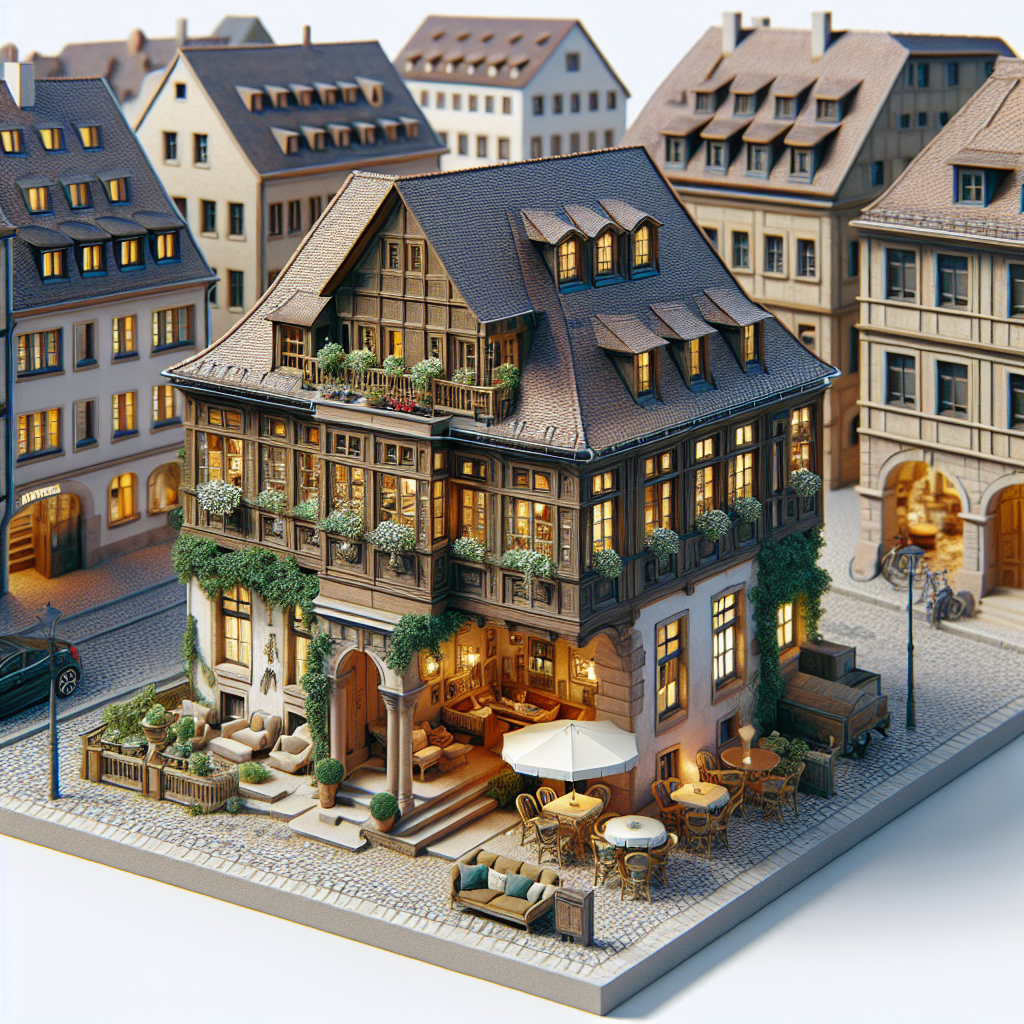

In [5]:
offers_media = []
for idx, offer in enumerate(offer_descriptions[top_key]):
    print(f"Creating image for {idx + 1}. item")
    price_attribute = "pricy" if offer["Price"] > 400_000 else "affordable"
    space_attribute = "confined" if offer["Living space"] < 200 else "roomy"
    query = f'A {price_attribute} house with a realisitc style in {city}, {offer["Neighborhood"]} living space is {space_attribute}, vicinity is like {offer["Neighborhood description"]}'    
    image = client.query_image_generator(query)
    offers_media.append((idx, query, image))
    
display(offers_media[0][2])

as a last step all the created data is exported and permanently stored for further usage in the other Jupyter notebook _real_estate_agent.ipynb_

In [6]:
import pickle
import os
from Common import FRESH_ASSETS_FILE_PATH, ExportAsset, RealEstateAttributes
    
export_data = []
for item in offers_media:
    
    idx = item[0]
    subtitle = item[1]
    image = item[2]
    description = offer_descriptions[top_key][idx]
    
    attributes = RealEstateAttributes(
        description["Neighborhood"],
        description["Price"],
        description["Bedrooms"],
        description["Bathrooms"],
        description["Living space"],
        description["Neighborhood description"],
        description["Parking space"],
        description["Heating"],
        int(description["Internet"].lower().replace("mbps", "").replace(" ","")) # the LLM is rather persistent adding the unit here 
    )
    
    export_data.append(ExportAsset(
        attributes,
        image,
        subtitle
        ))
    
with open(FRESH_ASSETS_FILE_PATH, 'wb') as file_handle:
    pickle.dump(export_data, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
